In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import utils
plt.ion()
plt.show()

In [24]:
%load_ext autoreload
import importlib
importlib.reload(utils)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'utils' from '/home/lsc/pyprojs/tmi_mvts_transformer/src/utils/__init__.py'>

# Summary

When processing a large number of datasets which can potentially have different data distributions, we are confronted with the following considerations:
- Is the data distribution unimodal and if it is the case, which model best approximates it( uniform distribution, T-distribution, chi-square distribution, cauchy distribution, etc)?
- If the data distribution is multimodal, can we automatically identify the number of modes and provide more granular descriptive statistics?
- How can we estimate the probability density function of a new dataset?


This notebook tackles the following subjects:

- Histograms vs probability density function approximation
- Kernel density estimations
- Choice of optimal bandwidth: Silverman/ Scott/ Grid Search Cross Validation
- Statistical tests for unimodal distributions
- DIP test for unimodality
- Identification of the number of modes of a data distribution based on the kernel density estimation

In [25]:
i = 256
trj = np.load(f'../data/SHL_features/clean_trj_segs.npy', allow_pickle=True)[i]
fs = np.load(f'../data/SHL_features/clean_multi_feature_segs.npy', allow_pickle=True)[i]

d = fs[2]
v = fs[3]
a = fs[4]
j = fs[5]
hc = fs[7]
hcr = fs[8]

x = trj[0]
y = trj[1]
data = x
trj = np.array((x, y)).T

# Kernel density estimations

Kernel density estimations are dependent on an arbitrary bandwidth which governs how smooth is the returned approximation. The example below illustrates the effect of various bandwidth values:

In [26]:
def getKernelDensityEstimation(values, x, bandwidth = 0.2, kernel = 'gaussian'):
    model = KernelDensity(kernel = kernel, bandwidth=bandwidth)
    model.fit(values[:, np.newaxis])
    log_density = model.score_samples(x[:, np.newaxis])
    return np.exp(log_density)

# Methods for selecting the optimal banwidth for the kernel density estimation

In order to identify the optimal bandwidth, there are a few types of approaches:

- Silverman's rule of thumb: assumes Gaussian distribution for the unknown density. It is not the most optimal bandwidth selector but is used either as a very fast reasonably good estimator or as a first estimator in multistage bandwidth selectors. More precise solve-the-equation plug-in rules use estimation of integrated squared density derivative functional to estimate the optimal bandwidth. They demand high computations to solve a non-linear equation using iterative methods. They use ROT as a very first estimate
- Scott's rule of thumb:is optimal for random samples of normally distributed data, in the sense that it minimizes the integrated mean squared error of the density estimate.  

These 2 methods have the advantage of being computationally fast, but they usually give too few bins and that it is likely to underfit the underlying data distribution. Both methods have been implemented in statsmodels package and illustrated below.
- Methods based on cross validation: statsmodels comes with an cv bandwidth parameter. Alternatively, we can implement a grid search cross validation. Unlike the first 2 methods, performing a grid search is likely to be more computationally expensive, especially for larger datasets

In [27]:
from statsmodels.nonparametric.bandwidths import bw_silverman, bw_scott, select_bandwidth

In [28]:
silverman_bandwidth = bw_silverman(data)

# select bandwidth allows to set a different kernel
silverman_bandwidth_gauss = select_bandwidth(data, bw = 'silverman', kernel = 'gauss')

scott_bandwidth = bw_scott(data)

In [29]:
def bestBandwidth(data, minBandwidth = 0.1, maxBandwidth = 2, nb_bandwidths = 30, cv = 30):
    """
    Run a cross validation grid search to identify the optimal bandwidth for the kernel density
    estimation.
    """
    from sklearn.model_selection import GridSearchCV
    model = GridSearchCV(KernelDensity(),
                        {'bandwidth': np.linspace(minBandwidth, maxBandwidth, nb_bandwidths)}, cv=cv) 
    model.fit(data[:, None])
    return model.best_params_['bandwidth']

cv_bandwidth = bestBandwidth(data)

In [30]:
print(f"Silverman bandwidth = {silverman_bandwidth}")
print(f"Scott bandwidth = {scott_bandwidth}")
print(f"CV bandwidth = {cv_bandwidth}")

Silverman bandwidth = 0.0015214463778940638
Scott bandwidth = 0.0017902352379886813
CV bandwidth = 0.1


As expected, the first Silverman and Scott return larger bandwidth values which lead to bigger bins and thus the loss of information about the data distribution.  

Statsmodels allows for an automatic search of the optimal bandwidth based on cross validation and a maximum likelihood operator:

In [31]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate
stats_models_cv = KDEMultivariate(data, 'c', bw = 'cv_ml').pdf(x)

/home/lsc/miniconda3/envs/DeepL/lib/python3.8/site-packages/statsmodels/nonparametric/kernel_density.py:158: RuntimeWarning: invalid value encountered in log
  L += func(f_i)


## Plot the different approximations

# Statistical tests for unimodal distributions

There are a number of statistical tests addressing the data modality problem:
- DIP test
- excess mass test
- MAP test
- mode existence test
- runt test
- span test
- saddle test

Unfortunately, not many have been implemented in python open source libraries.

https://en.wikipedia.org/wiki/Multimodal_distribution

## DIP Test

The following python package https://github.com/BenjaminDoran/unidip provides an implementation of the dip test and also a functionality to ecursively extracts peaks of density in the data utilizing the Hartigan Dip-test of Unimodality.

For installation:  
#!pip install unidip

The second value is the dip test p-value which < 0.05 shows that our data is not unimodal.

When trying the functionality on a gaussian distribution we get one interval and a big p-value.

# Identify and plot local maximum values of the KDE 

Once we have an estimation of the kernel density funtction we can determine if the distribution is multimodal and identify the maximum values or peaks corresponding to the modes.  
This can be done by identifying the points where the first derivative changes the sign. The method getInflexion points can return by default all inflexion points ( minima + maxima) or just a selection (typeOfInflexion = 'max'/ 'min').  
The plot below depicts these maximum values which may correspond to multiple modes of the data distribution. The analysis can be continued by setting a threshold based on the height of the peak in order to filter out some less significant values.

In [32]:
def getExtremePoints(data, typeOfInflexion = None, maxPoints = None):
    """
    This method returns the indeces where there is a change in the trend of the input series.
    typeOfInflexion = None returns all inflexion points, max only maximum values and min
    only min,
    """
    a = np.diff(data)
    asign = np.sign(a)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    idx = np.where(signchange ==1)[0]

    if typeOfInflexion == 'max' and data[idx[0]] < data[idx[1]]:
        idx = idx[1:][::2]

    elif typeOfInflexion == 'min' and data[idx[0]] > data[idx[1]]:
        idx = idx[1:][::2]
    elif typeOfInflexion is not None:
        idx = idx[::2]

    # sort ids by min value
    if 0 in idx:
        idx = np.delete(idx, 0)
    if (len(data)-1) in idx:
        idx = np.delete(idx, len(data)-1)
    idx = idx[np.argsort(data[idx])]
    # If we have maxpoints we want to make sure the timeseries has a cutpoint
    # in each segment, not all on a small interval
    if maxPoints is not None:
        idx= idx[:maxPoints]
        if len(idx) < maxPoints:
            return (np.arange(maxPoints) + 1) * (len(data)//(maxPoints + 1))

    return idx

Mode values [51.38788085 51.38807373 51.39395995 51.39704408 51.39735379 51.3974032
 51.3974035 ]


FileNotFoundError: [Errno 2] No such file or directory: 'figures/max.jpg'

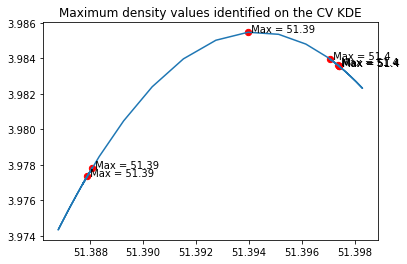

In [33]:
kde = getKernelDensityEstimation(data, x, bandwidth=cv_bandwidth)
idx = getExtremePoints(kde, typeOfInflexion='max')
plt.plot(x,kde)
ax = plt.gca()
for i in idx:
    plt.scatter(x[i], kde[i], s= 40, c = 'red')

for i in idx:
    ax.annotate(f' Max = {round(x[i], 2)}', (x[i], kde[i]))

plt.title('Maximum density values identified on the CV KDE')
modeValues =np.sort(x[idx])
print(f'Mode values {modeValues}')
plt.savefig('figures/max.jpg', bbox_inches='tight')

We notice that the obtained values correspond to the initial anchors of the generated distribution.

# Resources
- https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
- https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html
- https://en.wikipedia.org/wiki/Multimodal_distribution